# M03. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Created: 4/19/2024
- Updated: 2/1/2025

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"
%run "U5. Models.ipynb"

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Data

##### Park x Weather Factors

In [3]:
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Multiplier Dataset.csv"))

##### Plate Appearances

In [4]:
complete_dataset = pd.read_csv(os.path.join(baseball_path, "Complete Dataset - Adjusted.csv"))

##### Steamer

In [5]:
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')

In [6]:
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')

### Clean

##### MLB Stats API

In [7]:
%%time
complete_dataset[batter_inputs] = scale_batter_stats.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = scale_pitcher_stats.transform(complete_dataset[pitcher_inputs])

CPU times: total: 2.19 s
Wall time: 2.26 s


##### Steamer

Clean

In [8]:
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

Scale

In [9]:
steamer_hitters_df2[batter_stats_fg] = scale_batter_stats_steamer.transform(steamer_hitters_df2[batter_stats_fg])

Read in pitchers

Clean

In [10]:
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

Scale

In [11]:
steamer_pitchers_df2[pitcher_stats_fg] = scale_pitcher_stats_steamer.transform(steamer_pitchers_df2[pitcher_stats_fg])

##### Merge

Format dates

In [12]:
complete_dataset['date_time'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')
complete_dataset['date_time_copy'] = complete_dataset['date_time'].copy()
steamer_hitters_df2['date_time'] = pd.to_datetime(steamer_hitters_df2['date'], format='%Y%m%d')
steamer_pitchers_df2['date_time'] = pd.to_datetime(steamer_pitchers_df2['date'], format='%Y%m%d')

steamer_hitters_df2.rename(columns={'mlbamid': 'batter'}, inplace=True)
steamer_pitchers_df2.rename(columns={'mlbamid': 'pitcher'}, inplace=True)

Sort to prep for merge

In [13]:
complete_dataset.sort_values('date_time', inplace=True)
steamer_hitters_df2.sort_values('date_time', inplace=True)
steamer_pitchers_df2.sort_values('date_time', inplace=True)

Drop unnecessary columns

In [14]:
steamer_hitters_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)
steamer_pitchers_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)

Remove missing pitchers (occurs occassionally in 2014)

In [15]:
steamer_pitchers_df2 = steamer_pitchers_df2[~steamer_pitchers_df2['pitcher'].isna()].reset_index(drop=True)

Set data types

In [16]:
complete_dataset['batter'] = complete_dataset['batter'].astype(int).astype(str)
complete_dataset['pitcher'] = complete_dataset['pitcher'].astype(int).astype(str)
steamer_hitters_df2['batter'] = steamer_hitters_df2['batter'].astype(int).astype(str)
steamer_pitchers_df2['pitcher'] = steamer_pitchers_df2['pitcher'].astype(int).astype(str)

Merge asof most recent date in Steamer

In [17]:
complete_merged_df = pd.merge_asof(
    complete_dataset,
    steamer_hitters_df2,
    on='date_time',
    by='batter',  # Group by 'batter'
    direction='backward'  # Use 'backward', 'forward', or 'nearest' as appropriate
)
# Correct datetime (might be unnecessary, but I'm not sure which date_time it takes after the merge)
complete_merged_df['date_time'] = complete_merged_df['date_time_copy'].copy()

complete_merged_df = pd.merge_asof(
    complete_merged_df,
    steamer_pitchers_df2,
    on='date_time',
    by='pitcher',  # Group by 'batter'
    direction='backward'  # Use 'backward', 'forward', or 'nearest' as appropriate
)

##### Impute

For players with insufficient sample sizes, stats are imputed

Option 1: Steamer

First, remove from dataset if ever missing FG/Steamer stats

In [18]:
complete_merged_df = complete_merged_df[~complete_merged_df['b1_rate'].isna()]
complete_merged_df = complete_merged_df[~complete_merged_df['H9'].isna()]

In [19]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L', 'imp_b']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L', 'imp_p']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = impute_batter_stats.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = impute_pitcher_stats.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

Option 2: 0s

In [20]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Select Data

Drop early observations

In [21]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2015-07-01']

Drop atypical events

In [22]:
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"')

Drop observations from inactive parks

In [23]:
active_parks = list(team_map['VENUE_ID'].astype(int))
complete_merged_df = complete_merged_df[complete_merged_df['venue_id'].astype(int).isin(active_parks)]

### Select Variables

Batter Inputs

In [24]:
batter_input_list = batter_inputs

Pitcher Inputs

In [25]:
pitcher_input_list = pitcher_inputs

Hand Inputs

In [26]:
hand_input_list = ['p_L', 'b_L']

Imputation Inputs

In [27]:
imp_input_list = ['imp_b', 'imp_p']

Starter Input(s)

In [28]:
starter_input_list = ['starter']

Cumulative Inning Inputs

In [29]:
cumulative_inning_input_list = [col for col in complete_merged_df.columns if col.endswith("_inning")]

In [30]:
cumulative_inning_input_list.remove('rbi_inning')

Cumulative Game Inputs

In [31]:
cumulative_game_input_list = [col for col in complete_merged_df.columns if col.endswith("_game")]

In [32]:
cumulative_game_input_list.remove('rbi_game')

Game State Inputs

In [33]:
complete_merged_df['winning'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore']).astype(int)
complete_merged_df['winning_big'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore'] + 3).astype(int)

In [34]:
game_state_input_list = ['onFirst', 'onSecond', 'onThird', 'top', 'score_diff', 'prePitcherScore', 'preBatterScore', 'winning', 'winning_big', 'times_faced']

Inning Inputs

In [35]:
for inning in range(1, 12):
    complete_merged_df[f'inning_{inning}'] = (complete_merged_df['inning'] == inning).astype(int)
complete_merged_df['inning_11'] = (complete_merged_df['inning'] >= 11).astype(int)

In [36]:
inning_input_list = [col for col in complete_merged_df.columns if col.startswith("inning_")]

Out Inputs

In [37]:
for out in range(0, 3):
    complete_merged_df[f'outs_{out}'] = (complete_merged_df['outs_pre'] == out).astype(int)

In [38]:
out_input_list = ['outs_0', 'outs_1', 'outs_2']

Venue Inputs

In [39]:
complete_merged_df['venue_id2'] = complete_merged_df['venue_id'].copy()
complete_merged_df = pd.get_dummies(complete_merged_df, columns=['venue_id2'], prefix='venue')

In [40]:
venue_input_list = [col for col in complete_merged_df.columns if col.startswith("venue_") and col != "venue_id"]

Multiplier Inputs

In [41]:
for event in events_list:
    # Assign multiplier for their 
    complete_merged_df[f'{event}_wfx'] = np.where(complete_merged_df['batSide'] == "L", complete_merged_df[f'{event}_wfx_l'], complete_merged_df[f'{event}_wfx_r'])

In [42]:
multiplier_input_list = [f'{event}_wfx' for event in events_list]

Inputs

In [43]:
input_list = batter_input_list + pitcher_input_list + hand_input_list + imp_input_list + starter_input_list + cumulative_inning_input_list + cumulative_game_input_list + game_state_input_list + inning_input_list + out_input_list + venue_input_list + multiplier_input_list

Outputs

In [44]:
output_list = ['is_out', 'eventsModel']

Other variables

In [45]:
additional_list = ['pa_b', 'pa_p', 'year', 'date', 'gamePk', 'atBatIndex', 'venue_id', 'batterName', 'pitcherName']

Variables to keep

In [46]:
keep_list = input_list + output_list + additional_list

### Shift

Many batter and pitcher stats are calculated at the end of the plate appearance. For prediction purposes, we need these stats coming into the plate appearance.

##### Batter Inputs

Sort

In [47]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [48]:
complete_merged_df[batter_inputs + ['ab_b', 'pa_b', 'imp_b']] = complete_merged_df.groupby(['batter', 'pitchHand'])[batter_inputs + ['ab_b', 'pa_b', 'imp_b']].shift(1)

##### Pitcher Inputs

Sort

In [49]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [50]:
complete_merged_df[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']] = complete_merged_df.groupby(['pitcher', 'batSide'])[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']].shift(1)

##### Inning Sums

Sort

In [51]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [52]:
complete_merged_df[cumulative_inning_input_list] = complete_merged_df.groupby(['gamePk', 'inning', 'pitcher'])[cumulative_inning_input_list].shift(1)
complete_merged_df[cumulative_inning_input_list] = complete_merged_df[cumulative_inning_input_list].fillna(0)

##### Game Sums

Sort

In [53]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [54]:
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df.groupby(['gamePk', 'pitcher'])[cumulative_game_input_list + ['times_faced']].shift(1)
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df[cumulative_game_input_list + ['times_faced']].fillna(0)

### Model Dataset

Create Model Dataset

In [55]:
model_dataset = complete_merged_df[keep_list]

model_dataset.dropna(subset=input_list, inplace=True)
model_dataset.reset_index(drop=True, inplace=True)

Free up memory

In [56]:
del complete_merged_df, complete_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2, multiplier_df,  batter_predictions, pitcher_predictions

In [57]:
n1 = len(input_list) + 1

### Train/Test Split

Split

In [58]:
np.random.seed(42)
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

Create masks to identify training and testing datasets

Note: to train on the entire dataset, you can simply set split = 0 for the entire dataset

In [59]:
training_mask = (model_dataset['split'] == 0)

### All

In [60]:
all_stat_list = []

##### Settings

In [61]:
layers = (n1,22,)
layers = (n1,n1,n1,n1,n1,n1)
layers_str = ''.join(str(x) for x in layers)
activation = 'relu'
max_iter = 100
alpha = 0.0001
learning_rate = 0.00001
batch_size='auto'
random_state = random.randint(1,99999)
num_models = 40

quantiles = 10

##### Loop

predict_all_195195195195195195_38280_20250411.sav
    Year  Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All      b1 0.143448  0.141187   1.016013 0.027286 0.000008   
1    All      b2 0.044402  0.044536   0.996990 0.008519 0.000003   
2    All      b3 0.004203  0.004228   0.994199 0.001961 0.000001   
3    All      bb 0.084315  0.085466   0.986538 0.034695 0.000016   
4    All      fo 0.123972  0.118290   1.048035 0.029217 0.000041   
5    All      go 0.230861  0.235592   0.979916 0.060659 0.000060   
6    All     hbp 0.010877  0.010332   1.052739 0.004670 0.000001   
7    All      hr 0.031842  0.031055   1.025333 0.013713 0.000002   
8    All      lo 0.058082  0.058930   0.985619 0.013307 0.000002   
9    All      po 0.047403  0.044801   1.058083 0.017710 0.000010   
10   All      so 0.220595  0.225583   0.977887 0.075756 0.000088   
11   All  is_out 0.680913  0.683196   0.996658 0.038829 0.000044   
12   All    wOBA 0.320084  0.317085   1.009459 0.041712 0.000059  

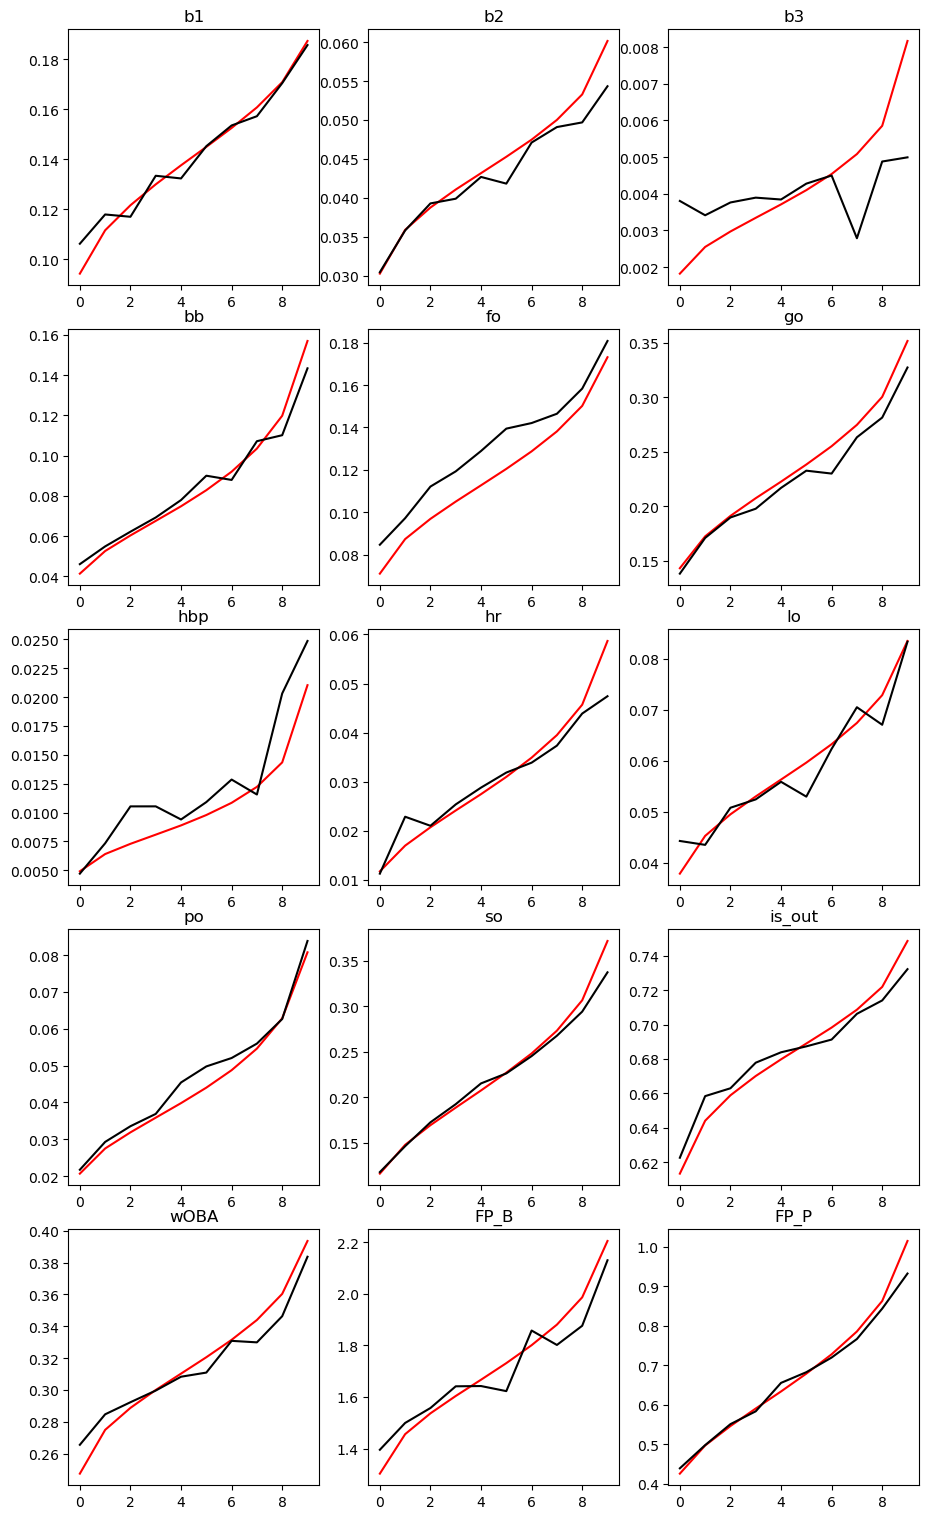

predict_all_195195195195195195_38281_20250411.sav
    Year  Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All      b1 0.143448  0.137771   1.041205 0.027839 0.000037   
1    All      b2 0.044402  0.046190   0.961286 0.008977 0.000008   
2    All      b3 0.004203  0.003938   1.067428 0.001625 0.000000   
3    All      bb 0.084315  0.086503   0.974709 0.035345 0.000020   
4    All      fo 0.123972  0.125890   0.984763 0.030638 0.000017   
5    All      go 0.230861  0.229843   1.004430 0.059825 0.000028   
6    All     hbp 0.010877  0.009604   1.132636 0.004879 0.000002   
7    All      hr 0.031842  0.032545   0.978398 0.014427 0.000004   
8    All      lo 0.058082  0.058191   0.998132 0.013472 0.000003   
9    All      po 0.047403  0.045299   1.046444 0.018269 0.000007   
10   All      so 0.220595  0.224227   0.983800 0.075013 0.000059   
11   All  is_out 0.680913  0.683450   0.996288 0.038888 0.000041   
12   All    wOBA 0.320084  0.318929   1.003623 0.041986 0.000048  

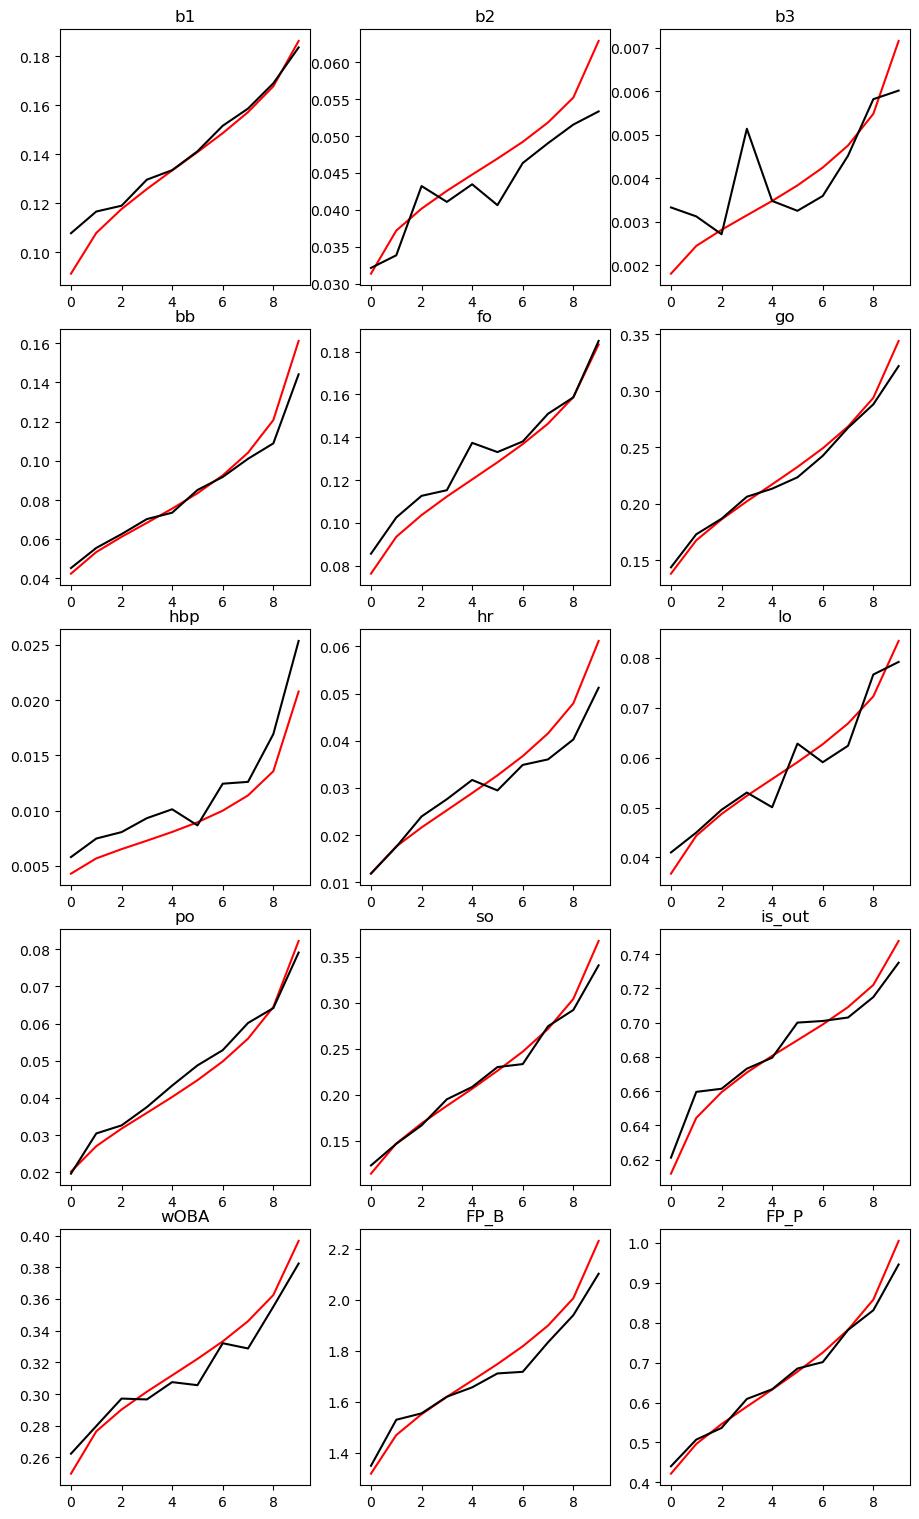

predict_all_195195195195195195_38282_20250411.sav
    Year  Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All      b1 0.143448  0.143347   1.000705 0.027408 0.000005   
1    All      b2 0.044402  0.044165   1.005368 0.008165 0.000003   
2    All      b3 0.004203  0.004129   1.018032 0.001646 0.000000   
3    All      bb 0.084315  0.080552   1.046723 0.032478 0.000017   
4    All      fo 0.123972  0.122394   1.012893 0.029663 0.000010   
5    All      go 0.230861  0.236716   0.975264 0.060274 0.000065   
6    All     hbp 0.010877  0.010361   1.049813 0.004436 0.000001   
7    All      hr 0.031842  0.031846   0.999856 0.014632 0.000004   
8    All      lo 0.058082  0.057958   1.002146 0.013097 0.000001   
9    All      po 0.047403  0.047874   0.990173 0.017997 0.000002   
10   All      so 0.220595  0.220659   0.999709 0.072746 0.000025   
11   All  is_out 0.680913  0.685601   0.993163 0.036763 0.000041   
12   All    wOBA 0.320084  0.316624   1.010928 0.041019 0.000047  

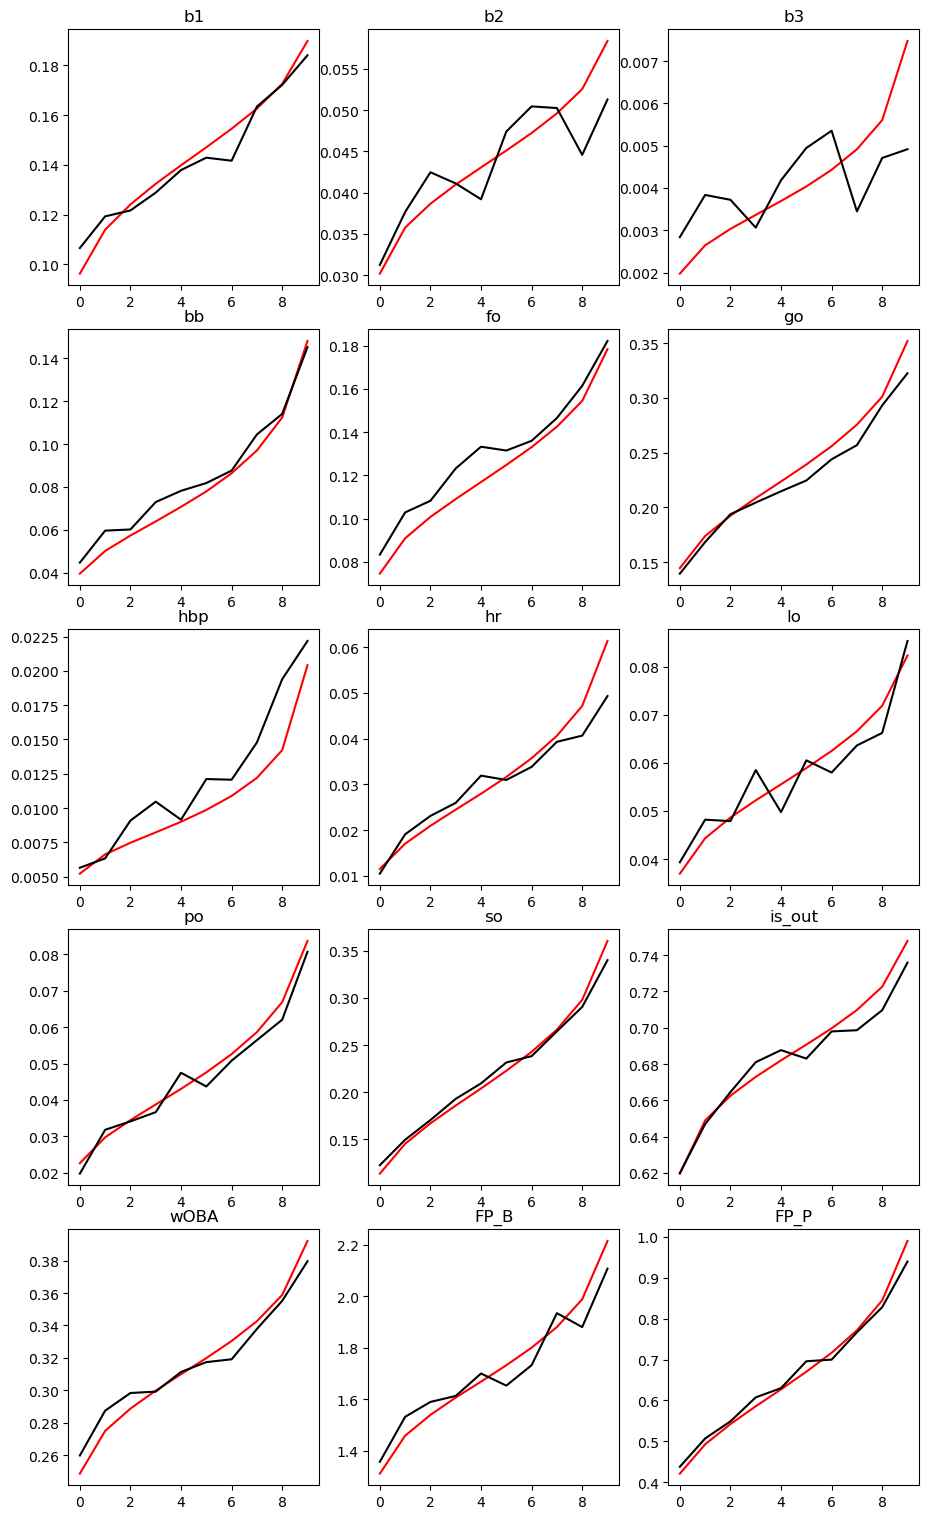

predict_all_195195195195195195_38283_20250411.sav
    Year  Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All      b1 0.143448  0.145293   0.987298 0.030283 0.000022   
1    All      b2 0.044402  0.043334   1.024628 0.008650 0.000004   
2    All      b3 0.004203  0.004396   0.956111 0.002111 0.000000   
3    All      bb 0.084315  0.084855   0.993645 0.036027 0.000018   
4    All      fo 0.123972  0.122741   1.010025 0.031393 0.000021   
5    All      go 0.230861  0.223969   1.030770 0.059221 0.000066   
6    All     hbp 0.010877  0.010825   1.004879 0.006147 0.000000   
7    All      hr 0.031842  0.031112   1.023472 0.014294 0.000003   
8    All      lo 0.058082  0.057617   1.008087 0.014164 0.000003   
9    All      po 0.047403  0.048253   0.982396 0.018985 0.000003   
10   All      so 0.220595  0.227606   0.969197 0.076162 0.000104   
11   All  is_out 0.680913  0.680185   1.001069 0.039923 0.000048   
12   All    wOBA 0.320084  0.319517   1.001775 0.042569 0.000049  

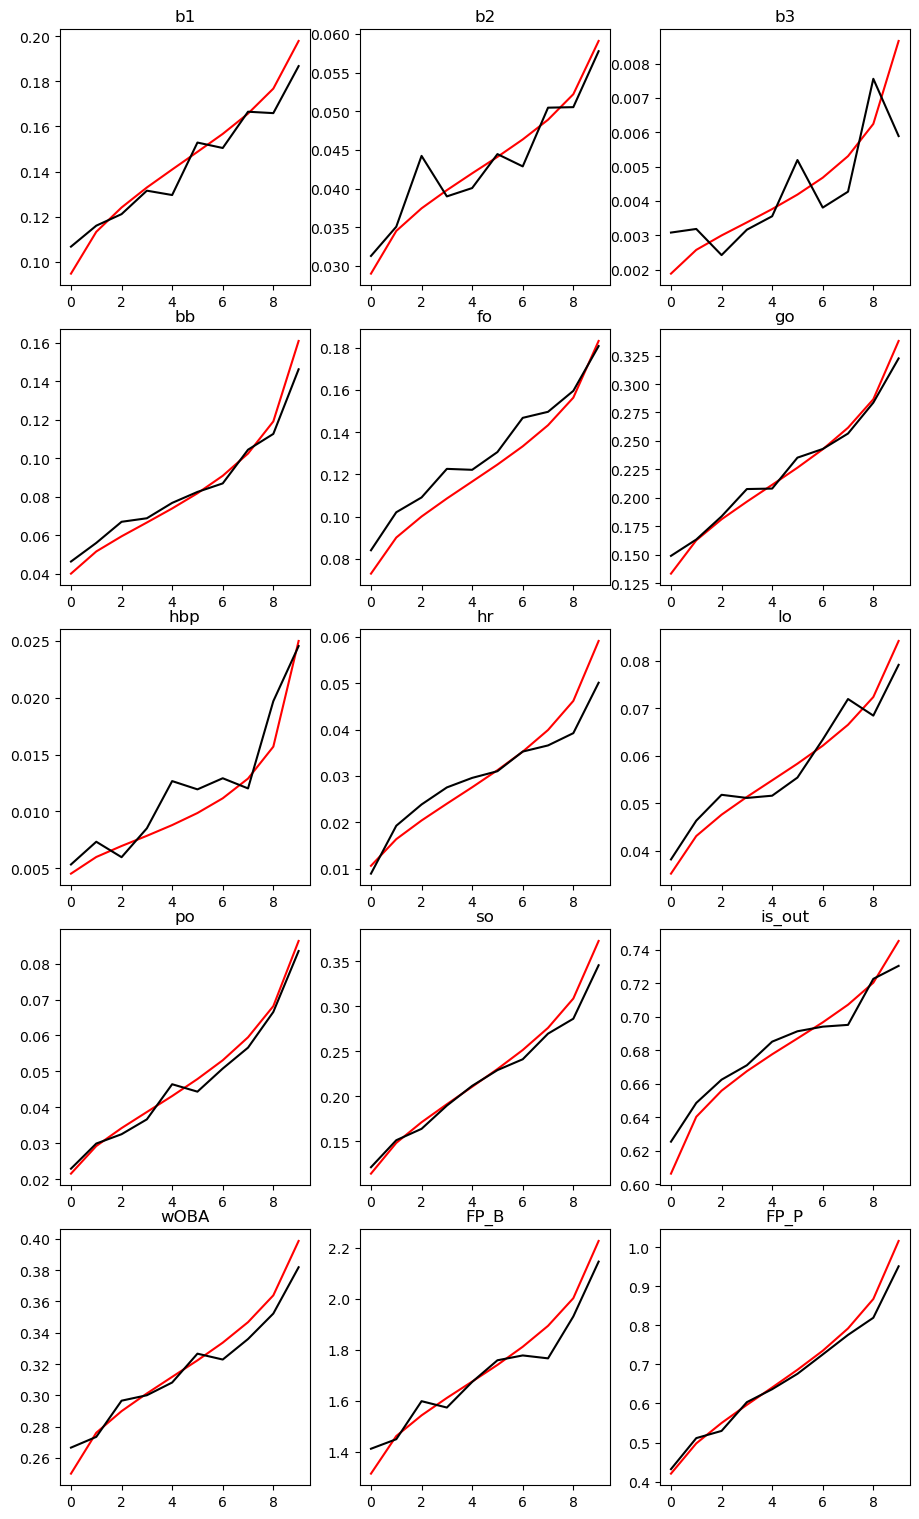

predict_all_195195195195195195_38284_20250411.sav
    Year  Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All      b1 0.143448  0.143320   1.000893 0.027985 0.000004   
1    All      b2 0.044402  0.043557   1.019393 0.008498 0.000005   
2    All      b3 0.004203  0.004618   0.910190 0.001700 0.000001   
3    All      bb 0.084315  0.087147   0.967512 0.034467 0.000019   
4    All      fo 0.123972  0.123056   1.007437 0.029370 0.000010   
5    All      go 0.230861  0.226152   1.020822 0.057179 0.000028   
6    All     hbp 0.010877  0.011454   0.949695 0.005191 0.000001   
7    All      hr 0.031842  0.033689   0.945164 0.014499 0.000007   
8    All      lo 0.058082  0.060765   0.955853 0.013612 0.000011   
9    All      po 0.047403  0.048313   0.981162 0.017961 0.000002   
10   All      so 0.220595  0.217929   1.012231 0.072319 0.000026   
11   All  is_out 0.680913  0.676216   1.006946 0.037052 0.000040   
12   All    wOBA 0.320084  0.325724   0.982685 0.040740 0.000065  

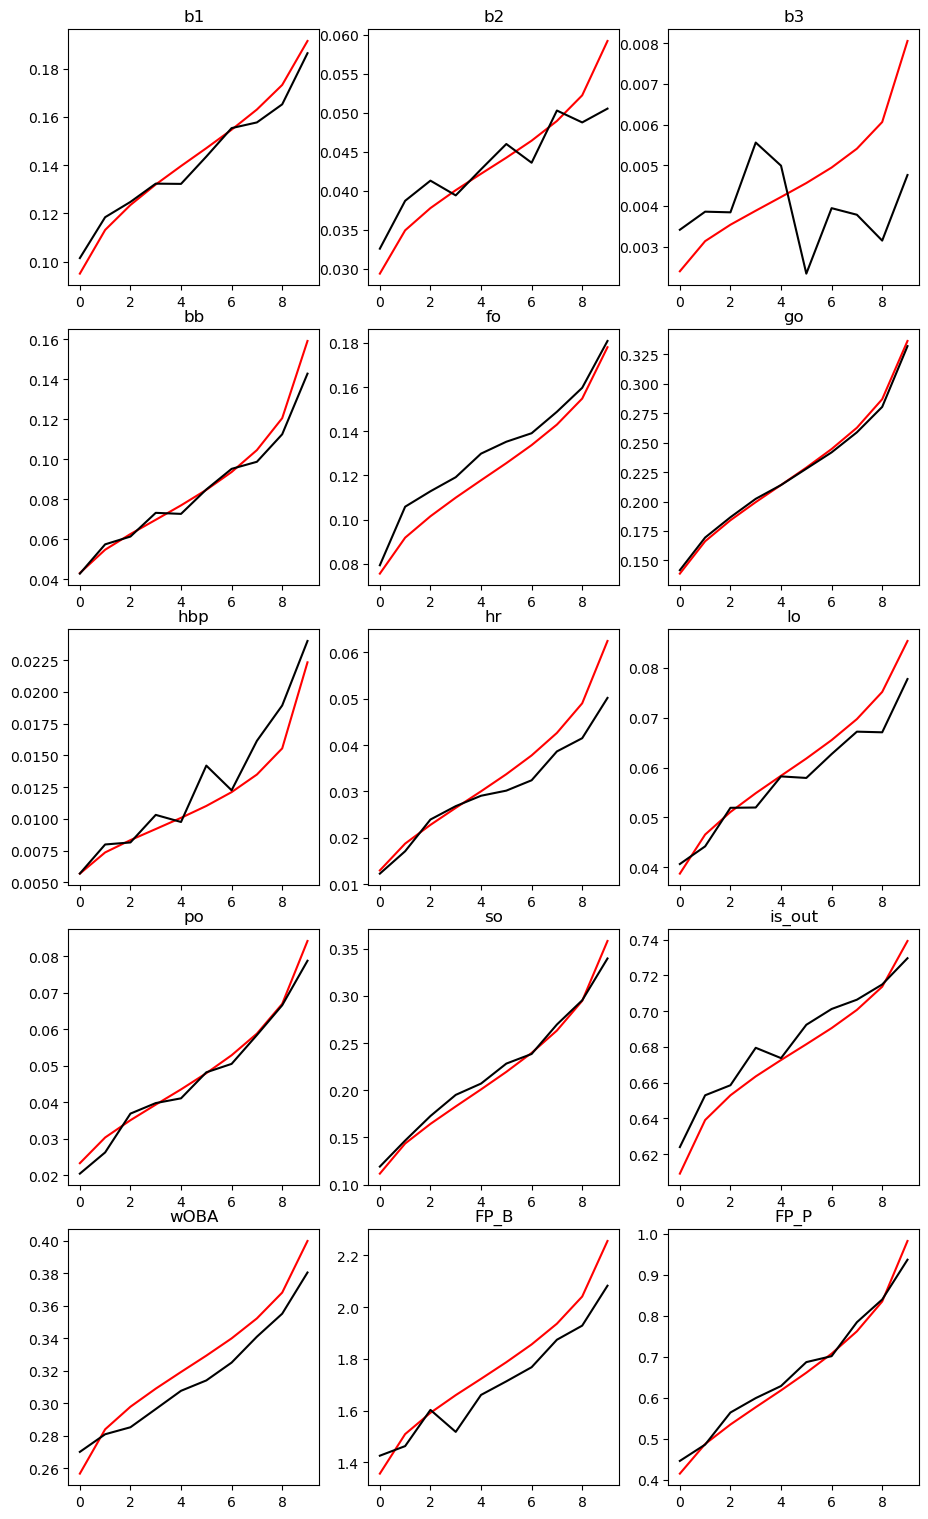

predict_all_195195195195195195_38285_20250411.sav
    Year  Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All      b1 0.143448  0.139534   1.028049 0.025927 0.000020   
1    All      b2 0.044402  0.045723   0.971102 0.008237 0.000005   
2    All      b3 0.004203  0.004452   0.944211 0.001828 0.000001   
3    All      bb 0.084315  0.084510   0.997698 0.032790 0.000005   
4    All      fo 0.123972  0.124505   0.995717 0.030049 0.000015   
5    All      go 0.230861  0.237230   0.973150 0.060527 0.000075   
6    All     hbp 0.010877  0.010626   1.023613 0.005103 0.000000   
7    All      hr 0.031842  0.031176   1.021360 0.013571 0.000002   
8    All      lo 0.058082  0.057645   1.007597 0.012547 0.000001   
9    All      po 0.047403  0.047415   0.999757 0.018619 0.000004   
10   All      so 0.220595  0.217185   1.015701 0.071118 0.000031   
11   All  is_out 0.680913  0.683979   0.995517 0.036006 0.000030   
12   All    wOBA 0.320084  0.317273   1.008863 0.039048 0.000031  

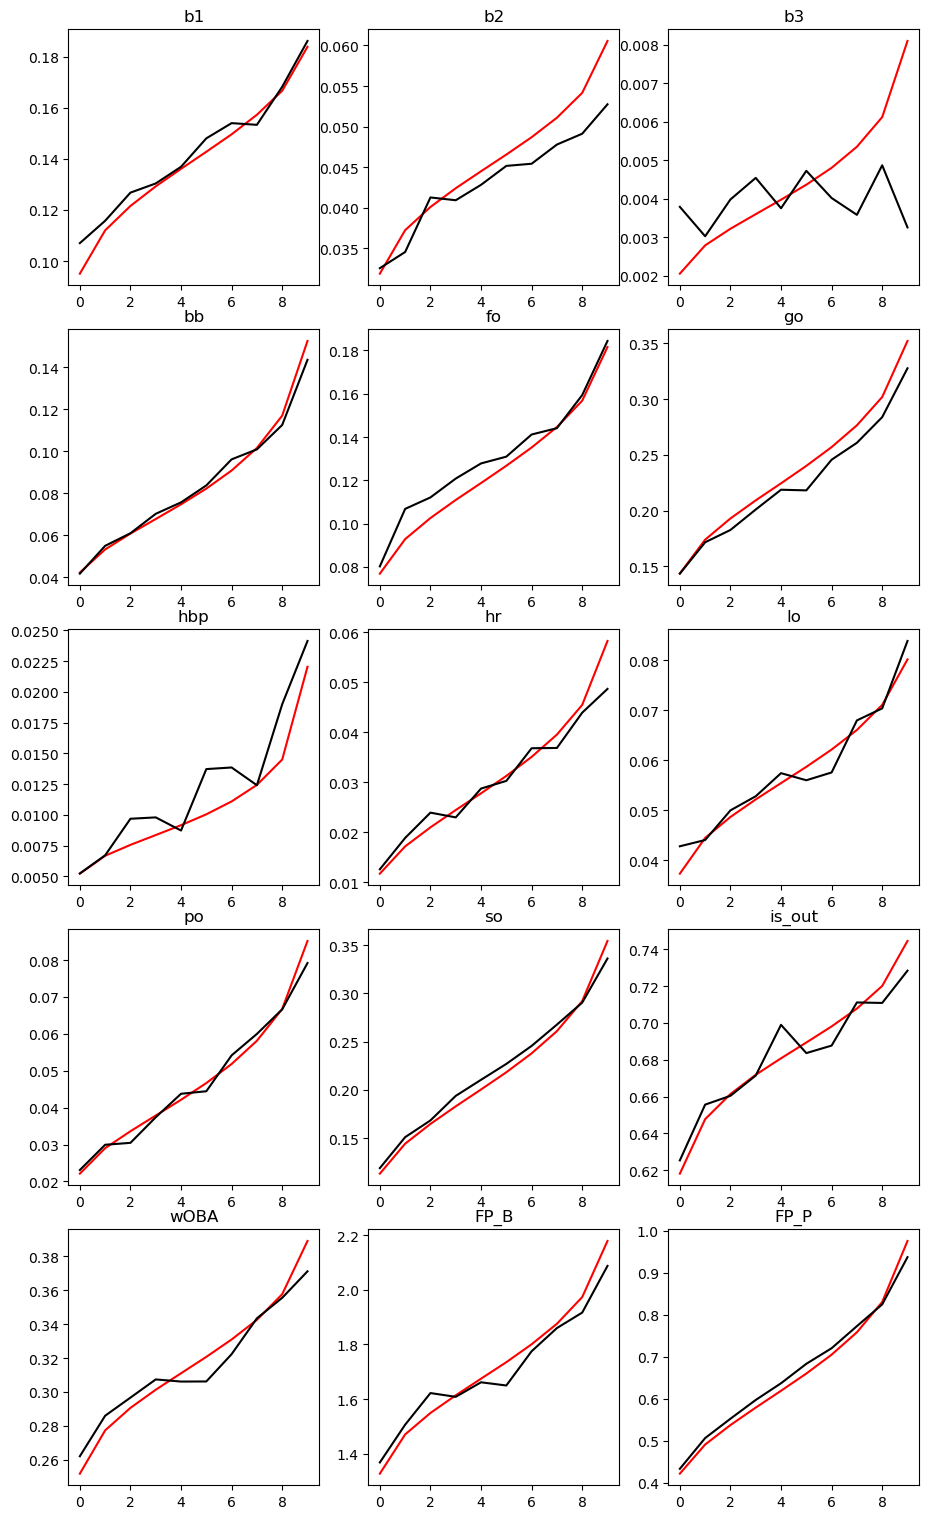

predict_all_195195195195195195_38286_20250411.sav
    Year  Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All      b1 0.143448  0.141248   1.015575 0.027723 0.000010   
1    All      b2 0.044402  0.045417   0.977650 0.008564 0.000003   
2    All      b3 0.004203  0.004254   0.987978 0.001962 0.000000   
3    All      bb 0.084315  0.084052   1.003137 0.034613 0.000010   
4    All      fo 0.123972  0.120526   1.028590 0.028174 0.000014   
5    All      go 0.230861  0.229019   1.008044 0.056826 0.000012   
6    All     hbp 0.010877  0.010406   1.045276 0.004519 0.000000   
7    All      hr 0.031842  0.032761   0.971953 0.014589 0.000004   
8    All      lo 0.058082  0.060971   0.952626 0.014032 0.000011   
9    All      po 0.047403  0.048844   0.970505 0.019337 0.000006   
10   All      so 0.220595  0.222504   0.991422 0.072088 0.000025   
11   All  is_out 0.680913  0.681863   0.998607 0.037626 0.000021   
12   All    wOBA 0.320084  0.320861   0.997580 0.040843 0.000032  

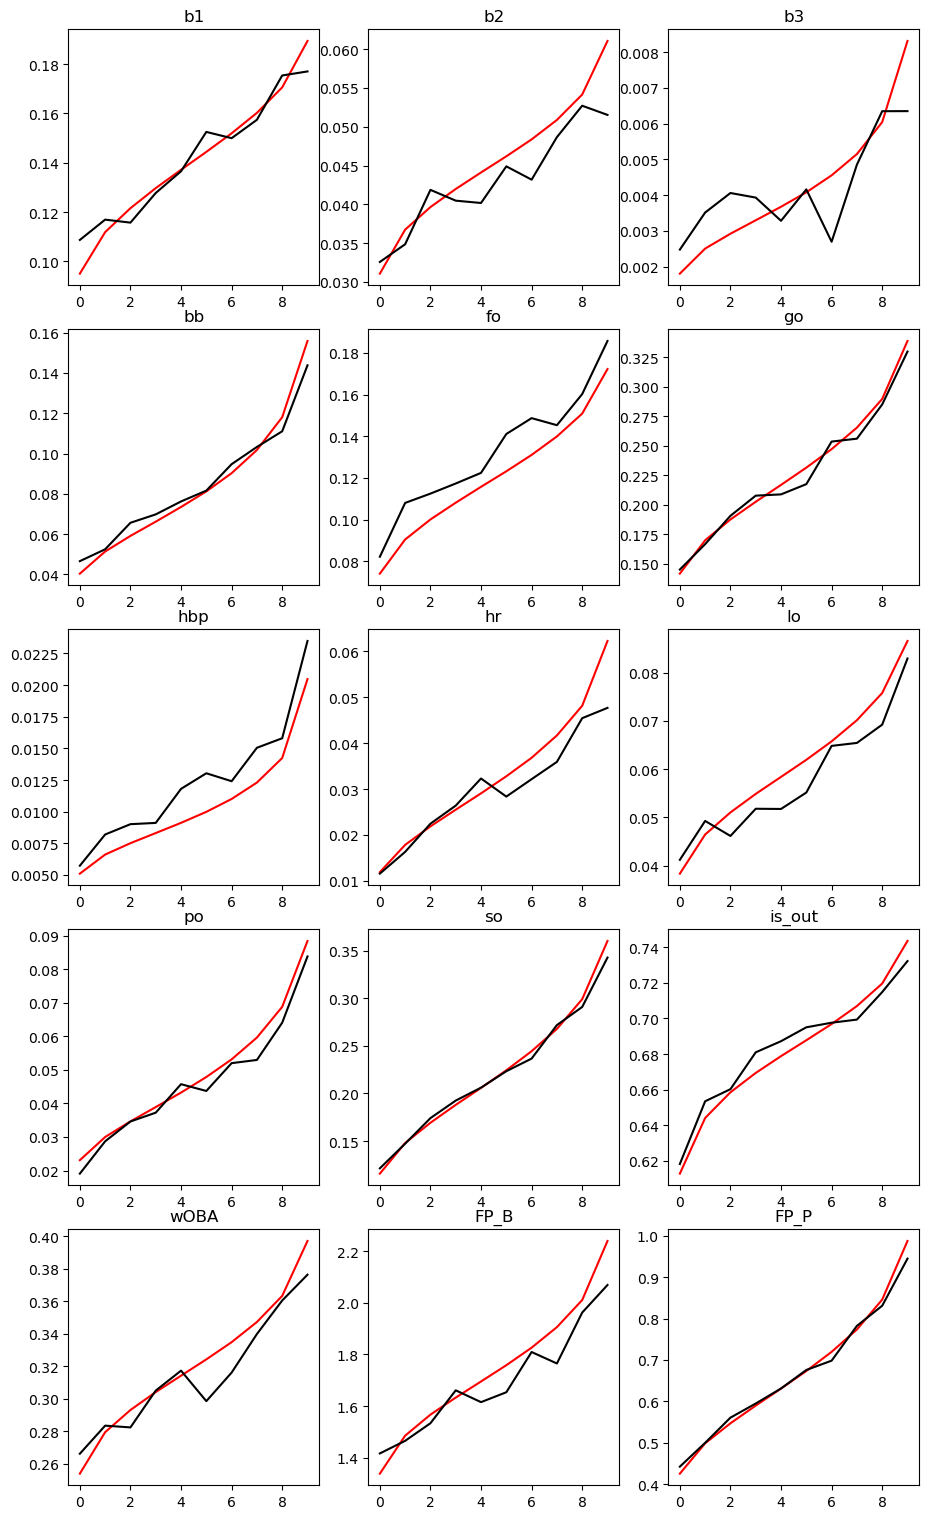

predict_all_195195195195195195_38287_20250411.sav



KeyboardInterrupt



In [62]:
%%time
for i in range(num_models):
    # Set filename
    all_filename = f"predict_all_{layers_str}_{random_state+i}_{todaysdate}.sav"
    print(all_filename)

    # Create Model
    predict_all = MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=False, alpha=alpha, 
                                learning_rate_init=learning_rate, early_stopping=True, random_state=random_state+i, max_iter=max_iter, batch_size=batch_size)

    # Fit
    predict_all.fit(model_dataset[training_mask][input_list], model_dataset[training_mask][['eventsModel']].values.ravel())

    # Save model
    pickle.dump(predict_all, open(os.path.join(model_path, "M03. Plate Appearances", all_filename), 'wb'))
    
    # Predict all types
    all_outputs = list(predict_all.classes_)
    all_outputs_pred = [x + "_pred" for x in all_outputs]
    
    model_dataset.loc[~training_mask, all_outputs_pred] = predict_all.predict_proba(model_dataset[~training_mask][input_list])


    ### Constructed Stats
    # FP - Outs
    model_dataset.loc[~training_mask, 'FP_P_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "fo").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "go").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "po").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "lo").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "so").astype(int) * 2.4866)

    model_dataset.loc[~training_mask, 'FP_P_pred'] = (model_dataset[~training_mask]['fo_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['go_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['po_pred'] * 0.2534 + 
                                                      model_dataset[~training_mask]['lo_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['so_pred'] * 2.4866)

    # FP - Safe
    model_dataset.loc[~training_mask, 'FP_B_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "b1").astype(int)  *  4.3665 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b2").astype(int)  *  6.8271 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b3").astype(int)  * 10.8503 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hr").astype(int)  * 15.2611 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "bb").astype(int)  *  2.8725 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hbp").astype(int) *  2.9639)

    model_dataset.loc[~training_mask, 'FP_B_pred'] = (model_dataset[~training_mask]['b1_pred']  *  4.3665 +
                                                      model_dataset[~training_mask]['b2_pred']  *  6.8271 +
                                                      model_dataset[~training_mask]['b3_pred']  * 10.8503 + 
                                                      model_dataset[~training_mask]['hr_pred']  * 15.2611 +
                                                      model_dataset[~training_mask]['bb_pred']  *  2.8725 +
                                                      model_dataset[~training_mask]['hbp_pred'] *  2.9639)

    # wOBA (roughly)
    model_dataset.loc[~training_mask, 'wOBA_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "b1").astype(int)  * 0.882 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b2").astype(int)  * 1.254 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b3").astype(int)  * 1.590 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hr").astype(int)  * 2.050 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "bb").astype(int)  * 0.689 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hbp").astype(int) * 0.720)

    model_dataset.loc[~training_mask, 'wOBA_pred'] = (model_dataset[~training_mask]['b1_pred']  * 0.882 +
                                                      model_dataset[~training_mask]['b2_pred']  * 1.254 +
                                                      model_dataset[~training_mask]['b3_pred']  * 1.590 + 
                                                      model_dataset[~training_mask]['hr_pred']  * 2.050 +
                                                      model_dataset[~training_mask]['bb_pred']  * 0.689 +
                                                      model_dataset[~training_mask]['hbp_pred'] * 0.720)
    
    # Out
    model_dataset['is_out_act'] = model_dataset['is_out'].copy()
    
    model_dataset.loc[~training_mask, 'is_out_pred'] = (model_dataset[~training_mask]['fo_pred'] +
                                                        model_dataset[~training_mask]['go_pred'] +
                                                        model_dataset[~training_mask]['po_pred'] + 
                                                        model_dataset[~training_mask]['lo_pred'] +
                                                        model_dataset[~training_mask]['so_pred'])

    
    # Quantiles
    year = 2024
    venue = 19
    
    for var in all_outputs:
        # Create actual outcome column
        model_dataset.loc[~training_mask, f'{var}_act'] = (model_dataset.loc[~training_mask, 'eventsModel'] == var).astype(int)
        
        # Create deciles
        model_dataset.loc[~training_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
    for var in ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        # Create deciles
        model_dataset.loc[~training_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()

    # All
    all_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
        all_df_list.append(all_df)
    
    all_dfs = pd.concat(all_df_list, axis=1).T
    
    # Year
    recent_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
        recent_df_list.append(recent_df)
    
    recent_dfs = pd.concat(recent_df_list, axis=1).T
    
    # DataFrame
    all_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
    all_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
    all_stat_df['File'] = all_filename
    all_stat_df['Layers'] = str(layers)
    all_stat_df['Models'] = num_models
    all_stat_df['State'] = random_state+i
    all_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

    print(all_stat_df)
    
    all_stat_list.append(all_stat_df)
    
    graph_options = ["", "_year", "_venue"]
    graph_index = 1
    graph = graph_options[graph_index]
    print(f"Graphing {graph}")

    # Create figures
    rows, columns = 5, 3
    fig, axs = plt.subplots(rows, columns, figsize=(9, 15))
    
    # Ensure that the number of plots doesn't exceed available subplots
    total_plots = rows * columns
    output_vars = all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']
    
    # Limit the number of plots to the available subplots
    output_vars = output_vars[:total_plots]
    
    for i, var in enumerate(output_vars):
        row = i // columns  # Calculate the row index based on the iteration
        col = i % columns   # Calculate the column index based on the iteration
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
        axs[row, col].set_title(var)
    
    # Add some space between subplots to prevent overlapping
    fig.tight_layout(pad=.0)
    
    # Show the figure
    plt.show()

In [64]:
all_stat_df = pd.concat(all_stat_list)
all_stat_df = all_stat_df.reset_index(drop=True)

In [66]:
subset = all_stat_df.query('Year == "2024"').query('Output == "wOBA"').query('1.005 > Multiplier > 0.995').reset_index(drop=True)
pareto_front = pareto_optimal(subset, ['MSE', 'Std. Dev'], ['Minimize', 'Maximize']).sort_values('Std. Dev')
pareto_front

,Year,Output,Actual,Predicted,Multiplier,Std. Dev,MSE,File,Layers,Models,State
2,2024,wOBA,0.310411,0.310384,1.000087,0.037908,0.000089,predict_all_195195195195195195_38285_20250411.sav,"(195, 195, 195, 195, 195, 195)",40,38285
1,2024,wOBA,0.310411,0.311335,0.997030,0.041305,0.000101,predict_all_195195195195195195_38283_20250411.sav,"(195, 195, 195, 195, 195, 195)",40,38283
